CNT_1_6_0.51.log.lammps
Max temperature: 923.48341
Max temperature index: 2771
Picosecond of Max temperature: 138.6


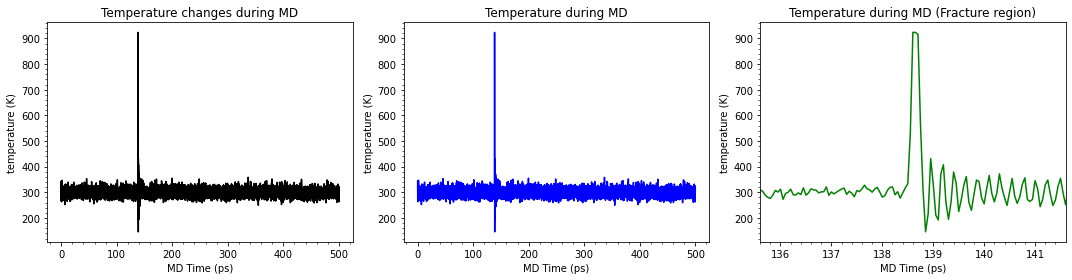

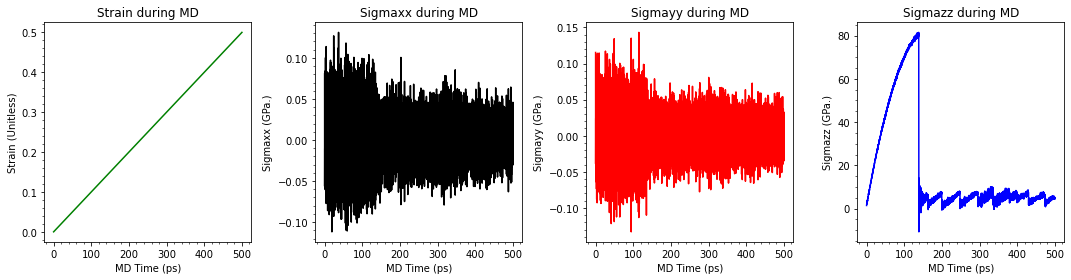

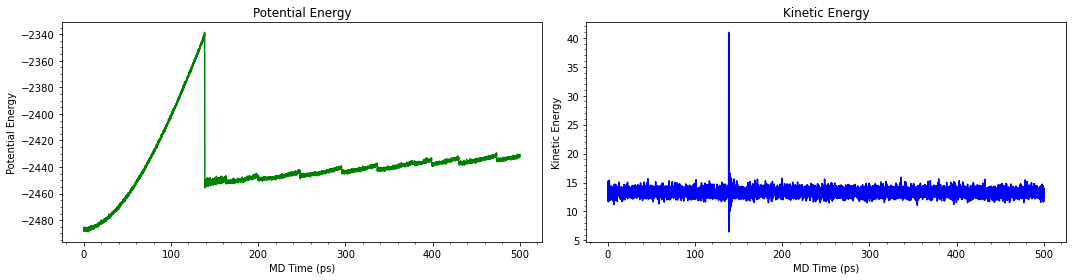

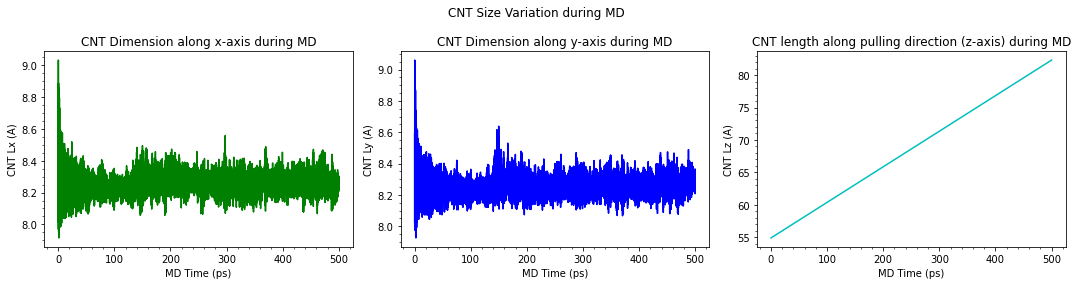

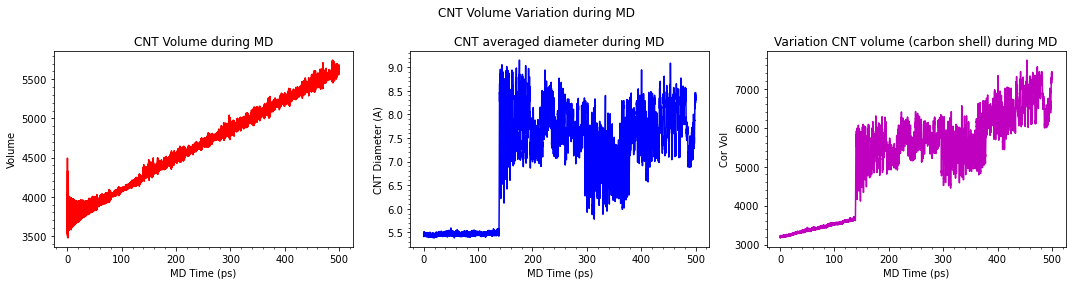

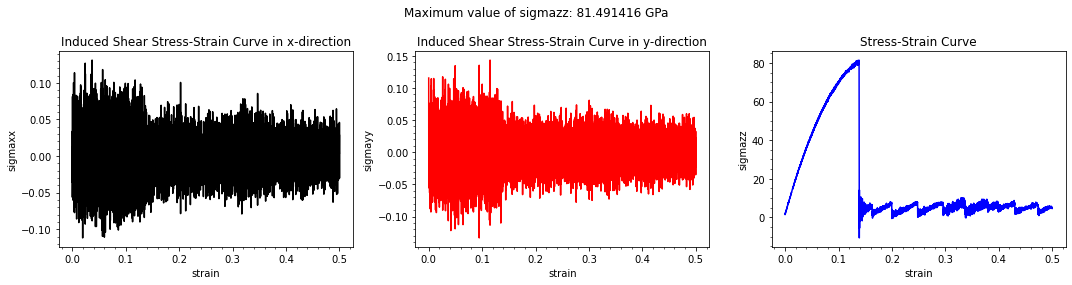

Directory 'CNT_1_6_0.51'_DAW created 


In [1]:
'''
CREDIT: Megan McCarthy & Drew Rohskopf
COMPILED: Brandon Ma

This program reads from a local directory and selects files that has log.lammps extension and
checks if a certain column exists before generating the data after said column is confirmed to exist
before converting it to .csv along with the file stem taken from the file's name without having to do it manually.
'''

import os, sys
import shutil
import numpy as np
import matplotlib.pyplot as plt

## Takes in files that has .lammps in their names. Limited to only the folder this scirpt is in.
all_the_log_files = [f for f in os.listdir() if f.endswith('.lammps') and not os.path.isdir(f)]

store_numpy_arrays = []

# for i, log_file in enumerate(all_the_log_files):
for i, log_file in enumerate(all_the_log_files):
    print(log_file)
    file_stem = log_file.replace('.log.lammps','')

    ## Get the text from the log file
    with open(log_file, 'r') as f:
        txt = f.readlines()

    col_check_str = 'Step          Temp         v_strain      v_sigmaxx      v_sigmayy'
    end_check_str = 'Loop time of '
    columns = None
    start_idx, end_idx = 0, len(txt)

    for line_idx, line in enumerate(txt):
        if col_check_str in line:
            columns = line.strip().split()
            start_idx = line_idx + 1
        if end_check_str in line and columns:
            end_idx = line_idx - 1

    ## PRINT DEBUG
    # print(columns)
    # print(start_idx,end_idx)
    # print(data0[-1:])

    data0 = txt[start_idx:end_idx]
    data = [row for row in data0 if len(row.split()) == 14]
    columns_entry = None
        
    ## write the CSV file
    csv_name = f'{file_stem}.csv'
    with open(csv_name, 'w') as f:
        f.write(",".join(columns) + "\n")
        for start_idx in data:
            ## Check if the rows has all the columns. If it is missing all 14 columns, remove the entire row.
            ## Suggested by Drew Rohskopf
            columns_entry = start_idx.strip().split()
            line_length = len(columns_entry)
            if (line_length==14):
                f.write(",".join(columns_entry) + "\n")
    
    ## Create an array to store each elements in a column
    arr = np.array([[float(element) for element in row.split()] for row in data])
    store_numpy_arrays.append(arr)
    
    ssc = arr.copy() ## stress strain curve array
    
    ## Get columns for MD Temperature 
    col_temp = ssc[:,1]
    snapshots = 1
    ps_arr = []
    
    ## Calculate picoseconds
    for counter in data:
        picoseconds = 0.0005 * 100 * snapshots
        ps = round(picoseconds,2)
        ps_arr.append(ps)
        #print(ps)
        snapshots = snapshots + 1
    
    ## One row, three columns of graphs for temperature
    fig, axes = plt.subplots(1, 3, figsize = [15,4])
    
    ## Find the max temperature and its index
    max_temp = np.max(col_temp)
    max_temp_index = col_temp.argmax()
    print('Max temperature:', max_temp)
    print('Max temperature index:', max_temp_index)
    
    ## Find use max temperature index to find the picosecond array's value
    ps_OfMaxTemp = ps_arr[max_temp_index]
    print('Picosecond of Max temperature:', ps_OfMaxTemp)
    
    xlim_index_max = ps_OfMaxTemp + 3
    xlim_index_min = ps_OfMaxTemp - 3
    
    ## Print Debug
#     print(xlim_index_max)
#     print(xlim_index_min)
    
    axes[0].plot(ps_arr, col_temp,label="temperature",c="k")
    axes[0].set_title('Temperature changes during MD')
    axes[0].set_xlabel('MD Time (ps)')
    axes[0].set_ylabel('temperature (K)')
    axes[0].yaxis.get_ticklocs(minor=True)
    axes[0].minorticks_on()

    axes[1].plot(ps_arr, col_temp,label="temperature",c="b")
    axes[1].set_title('Temperature during MD')
    axes[1].set_xlabel('MD Time (ps)')
    axes[1].set_ylabel('temperature (K)')
    axes[1].yaxis.get_ticklocs(minor=True)
    axes[1].minorticks_on()
    
    axes[2].plot(ps_arr, col_temp,label="temperature",c="g")
    axes[2].set_title('Temperature during MD (Fracture region)')
    axes[2].set_xlabel('MD Time (ps)')
    axes[2].set_ylabel('temperature (K)')
    axes[2].yaxis.get_ticklocs(minor=True)
    axes[2].minorticks_on()
    ## Focus on the fracture region
    axes[2].set_xlim(xlim_index_min, xlim_index_max)
    
    ## Create a PNG of the graphs and save it
    png_name = f'{file_stem}_MDTemperature.png'
    fig.tight_layout()
    plt.savefig(png_name, transparent=True)
    
    ## Save temperature data into csv
    np.savetxt(f'{file_stem}_MDTemperature.csv', np.c_[ps_arr,col_temp], delimiter=',', \
               header='MD Time (ps),Temperature (K)', comments='')
    
    
    ## One row, four columns of graphs for strain & stress
    fig, axes = plt.subplots(1, 4, figsize = [15,4])
    
    ## Takes the columns of strain and sigmas into the variables
    col_strain = ssc[:,2]
    col_sigmaxx = ssc[:,3] 
    col_sigmayy = ssc[:,4] 
    col_sigmazz = ssc[:,5] 
    
    axes[0].plot(ps_arr, col_strain,label="strain",c="g")
    axes[0].set_title('Strain during MD')
    axes[0].set_xlabel('MD Time (ps)')
    axes[0].set_ylabel('Strain (Unitless)')
    axes[0].yaxis.get_ticklocs(minor=True)
    axes[0].minorticks_on()
    
    axes[1].plot(ps_arr, col_sigmaxx,label="sigmaxx",c="k")
    axes[1].set_title('Sigmaxx during MD')
    axes[1].set_xlabel('MD Time (ps)')
    axes[1].set_ylabel('Sigmaxx (GPa.)')
    axes[1].yaxis.get_ticklocs(minor=True)
    axes[1].minorticks_on()
    
    axes[2].plot(ps_arr, col_sigmayy,label="sigmayy",c="r")
    axes[2].set_title('Sigmayy during MD')
    axes[2].set_xlabel('MD Time (ps)')
    axes[2].set_ylabel('Sigmayy (GPa.)')
    axes[2].yaxis.get_ticklocs(minor=True)
    axes[2].minorticks_on()
    
    axes[3].plot(ps_arr, col_sigmazz,label="sigmazz",c="b")
    axes[3].set_title('Sigmazz during MD')
    axes[3].set_xlabel('MD Time (ps)')
    axes[3].set_ylabel('Sigmazz (GPa.)')
    axes[3].yaxis.get_ticklocs(minor=True)
    axes[3].minorticks_on()
    
    ## Create a PNG of the graphs and save it
    png_name = f'{file_stem}_StressStrainResponse.png'
    fig.tight_layout()
    plt.savefig(png_name, transparent=True)
    
    
    ## One row, two columns of graphs for Potential & Kinetic energies
    fig, axes = plt.subplots(1, 2, figsize = [15,4])
    
    ## Takes the columns of Potential & Kinetic energies into the variables
    col_poteng = ssc[:,6]
    col_kineng = ssc[:,7]
    
    axes[0].plot(ps_arr, col_poteng,label="potential energy",c="g")
    axes[0].set_title('Potential Energy')
    axes[0].set_xlabel('MD Time (ps)')
    axes[0].set_ylabel('Potential Energy')
    axes[0].yaxis.get_ticklocs(minor=True)
    axes[0].minorticks_on()
    
    axes[1].plot(ps_arr, col_kineng,label="kinetic energy",c="b")
    axes[1].set_title('Kinetic Energy')
    axes[1].set_xlabel('MD Time (ps)')
    axes[1].set_ylabel('Kinetic Energy')
    axes[1].yaxis.get_ticklocs(minor=True)
    axes[1].minorticks_on()
    
    ## Create a PNG of the graphs and save it
    png_name = f'{file_stem}_Pot&KinEng.png'
    fig.tight_layout()
    plt.savefig(png_name, transparent=True)
    
    ## Save poteng and kineng data into csv
    np.savetxt(f'{file_stem}_Pot&KinEng.csv', np.c_[ps_arr,col_poteng,col_kineng], \
               delimiter=',', header='MD Time (ps),Potential Energy,Kinetic Energy', comments='')
    
    
    ## One row, three columns of graphs for size variation
    fig, axes = plt.subplots(1, 3, figsize = [15,4])
    
    ## Takes the columns of Potential & Kinetic energies into the variables
    col_Lx = ssc[:,8]
    col_Ly = ssc[:,9]
    col_Lz = ssc[:,10]
    
    axes[0].plot(ps_arr, col_Lx,label="Lx",c="g")
    axes[0].set_title('CNT Dimension along x-axis during MD')
    axes[0].set_xlabel('MD Time (ps)')
    axes[0].set_ylabel('CNT Lx (A)')
    axes[0].yaxis.get_ticklocs(minor=True)
    axes[0].minorticks_on()
    
    axes[1].plot(ps_arr, col_Ly,label="Ly",c="b")
    axes[1].set_title('CNT Dimension along y-axis during MD')
    axes[1].set_xlabel('MD Time (ps)')
    axes[1].set_ylabel('CNT Ly (A)')
    axes[1].yaxis.get_ticklocs(minor=True)
    axes[1].minorticks_on()
    
    axes[2].plot(ps_arr, col_Lz,label="Lz",c="c")
    axes[2].set_title('CNT length along pulling direction (z-axis) during MD')
    axes[2].set_xlabel('MD Time (ps)')
    axes[2].set_ylabel('CNT Lz (A)')
    axes[2].yaxis.get_ticklocs(minor=True)
    axes[2].minorticks_on()
    
    fig_info = 'CNT Size Variation during MD'
    fig.suptitle(fig_info)
    
    ## Create a PNG of the graphs and save it
    png_name = f'{file_stem}_Size.png'
    fig.tight_layout()
    plt.savefig(png_name, transparent=True)
    
    
    ## One row, three columns of graphs for volume variation
    fig, axes = plt.subplots(1, 3, figsize = [15,4])
    
    ## Takes the columns of volumes and diameter into the variables
    col_vol = ssc[:,11]
    col_cntdiameter = ssc[:,12]
    col_corvol = ssc[:,13]
    
    axes[0].plot(ps_arr, col_vol,label="volume",c="r")
    axes[0].set_title('CNT Volume during MD')
    axes[0].set_xlabel('MD Time (ps)')
    axes[0].set_ylabel('Volume')
    axes[0].yaxis.get_ticklocs(minor=True)
    axes[0].minorticks_on()
    
    axes[1].plot(ps_arr, col_cntdiameter,label="cnt_diameter",c="b")
    axes[1].set_title('CNT averaged diameter during MD')
    axes[1].set_xlabel('MD Time (ps)')
    axes[1].set_ylabel('CNT Diameter (A)')
    axes[1].yaxis.get_ticklocs(minor=True)
    axes[1].minorticks_on()
    
    axes[2].plot(ps_arr, col_corvol,label="corrected_volume",c="m")
    axes[2].set_title('Variation CNT volume (carbon shell) during MD')
    axes[2].set_xlabel('MD Time (ps)')
    axes[2].set_ylabel('Cor Vol')
    axes[2].yaxis.get_ticklocs(minor=True)
    axes[2].minorticks_on()
    
    fig_info = 'CNT Volume Variation during MD'
    fig.suptitle(fig_info)
    
    ## Create a PNG of the graphs and save it
    png_name = f'{file_stem}_Volume.png'
    fig.tight_layout()
    plt.savefig(png_name, transparent=True)
    
    ## Save size and volume data into csv
    np.savetxt(f'{file_stem}_Size&Volume.csv', np.c_[ps_arr,col_Lx,col_Ly,col_Lz,col_vol,col_cntdiameter,col_corvol], \
               delimiter=',', header='MD Time (ps),CNT Lx (A),CNT Ly (A),CNT Lz (A),Volume,CNT Diameter (A),Cor Vol', \
               comments='')
    
#     ## Print the columns entries for debugging purposes
#     print(col_strain)
#     print(col_sigmaxx)
#     print(col_sigmayy)
#     print(col_sigmazz)
#     print(col_temp)
#     print(ps_arr)

    ## One row, three columns of graphs for stress-strain curve
    fig, axes = plt.subplots(1, 3, figsize = [15,4])
        
    axes[0].plot(col_strain, col_sigmaxx,label="sigma_xx",c="k")
    axes[0].set_title('Induced Shear Stress-Strain Curve in x-direction')
    axes[0].set_xlabel('strain')
    axes[0].set_ylabel('sigmaxx')
    axes[0].yaxis.get_ticklocs(minor=True)
    axes[0].minorticks_on()

    axes[1].plot(col_strain, col_sigmayy,label="sigma_yy",c="r")
    axes[1].set_title('Induced Shear Stress-Strain Curve in y-direction')
    axes[1].set_xlabel('strain')
    axes[1].set_ylabel('sigmayy')
    axes[1].yaxis.get_ticklocs(minor=True)
    axes[1].minorticks_on()

    axes[2].plot(col_strain, col_sigmazz,label="sigma_zz",c="b")
    axes[2].set_title('Stress-Strain Curve')
    axes[2].set_xlabel('strain')
    axes[2].set_ylabel('sigmazz')
    axes[2].yaxis.get_ticklocs(minor=True)
    axes[2].minorticks_on()
        
    ## Find the max stress fracture and append it to the title for references
    max_sigmazz = np.max(col_sigmazz)
    fig_info = f"Maximum value of sigmazz: {max_sigmazz} GPa"
    fig.suptitle(fig_info)

    ## Create a PNG of the graphs and save it
    png_name = f'{file_stem}_StressStrain.png'
    fig.tight_layout()
    plt.savefig(png_name, transparent=False) ## Set to True for transparent images
    
    ## Save stress & strain response data into csv
    np.savetxt(f'{file_stem}_StressStrain.csv', np.c_[ps_arr,col_strain,col_sigmaxx,col_sigmayy,col_sigmazz], \
               delimiter=',', header='MD Time (ps),Strain,Sigmaxx (GPa),Sigmayy (GPa),Sigmazz (GPa)', comments='')

    ## Fit the graphs layout, then show and close. Required for normal scripts
    plt.show()
    plt.close()
    
    
    ## Initalize directory name to contain the graphs and csv.
    dir_dst = f'/home/bcma/Desktop/{file_stem}_DAW'
    os.mkdir(dir_dst)
    print("Directory '%s'_DAW created " %file_stem)
    
    ## Only accounts files that starts with CNT and initialize file path
    all_the_cnt_files = [f for f in os.listdir() if f.startswith(f'{file_stem}') and not os.path.isdir(f)]
    
    ## Set and reset counter
    i = 0
    
    ## Loops through the lists and transfer files to destination
    for file_stem in all_the_cnt_files:
        src = f'/home/bcma/AutomationDump/Components/AutomationComponents/AutomatePlotting/{all_the_cnt_files[i]}'
        shutil.move(src, dir_dst)
        i = i + 1
    